# Week 3 Inroduction
### Date: 19 Oct 2023

Last week you learned about different methods for segmenting an image into regions of interest. In this session you will get some experience coding image segmentation algorithms. Your task will be to code a simple statistical method that uses k-means clustering.

In [126]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
#to visualize the plots within the notebook
%matplotlib inline

# K-means Segmentation
K-means clustering is a well-known approach for separating data (often of high dimensionality) into
different groups depending on their distance. In the case of images this is a useful method for
segmenting an image into regions, provided that the number of regions (k) is known in advance. It is
based on the fact that pixels belonging to the same region will most likely have similar intensities. 

The algorithm is:

a) Given the number of clusters, k, initialise their centres to some values.

b) Go over the pixels in the image and assign each one to its closest cluster according to its distance to the centre of the cluster.

c) Update the cluster centres to be the average of the pixels added.

d) Repeat steps b and c until the cluster centres do not get updated anymore.

## 1. Use the k-means function in sklearn and see results

First, you can use the built-in kmeans function in sklearn and see the results. 
You can figure out how to this from the specification: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### Load image

Important Note: Don't forget to convert the image to float representation.

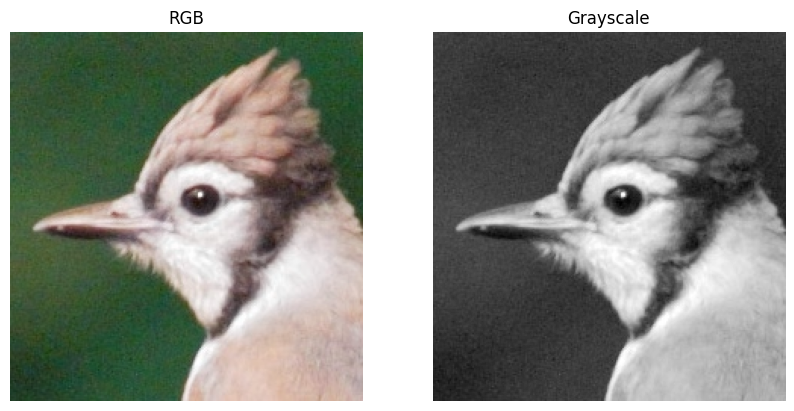

In [128]:
# Load image and conver to float representation
raw_img = cv2.imread("../images/sample_image.jpg") # change file name to load different images
raw_gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
img = raw_img.astype(np.float32) / 255.
gray_img = raw_gray_img.astype(np.float32) / 255.
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[0].set_title('RGB')
ax[1].imshow(gray_img, "gray")
ax[1].set_title('Grayscale')
for a in ax: a.axis('off')

### Results on Gray-scale Image

[[0.76224184]
 [0.28946102]]


Text(0.5, 1.0, 'SKlearn K-Means Grayscale')

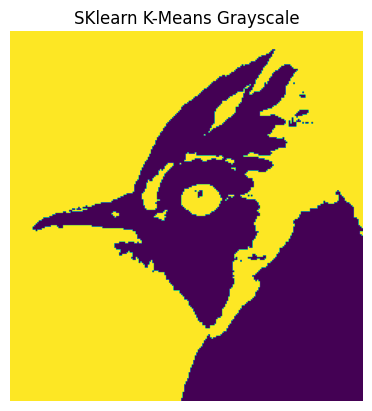

In [129]:
# Use SKlearn K-Mean clustering - Flatten image for method into (X,1)
sk_g_2_kmeans = KMeans(n_clusters=2, random_state=0).fit(gray_img.reshape(-1, 1))

# Unflatten back
sk_g_2_kmeans_labels = sk_g_2_kmeans.labels_.reshape(gray_img.shape[0], gray_img.shape[1])
plt.imshow(sk_g_2_kmeans_labels)
print(sk_g_2_kmeans.cluster_centers_)
plt.axis('off')
plt.title('SKlearn K-Means Grayscale')

### Results on RGB image

[[0.8224683  0.7527636  0.72861385]
 [0.23835173 0.3262214  0.22156417]]


Text(0.5, 1.0, 'SKlearn K-Means RGB')

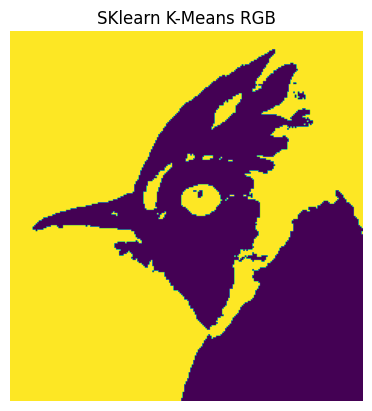

In [131]:
img_flat = img.reshape(-1, 3)
sk_rgb_2_kmeans = KMeans(n_clusters=2, random_state=0).fit(img_flat)

# Unflatten back
sk_rgb_2_kmeans_labels = sk_rgb_2_kmeans.labels_.reshape(img.shape[0], img.shape[1])
plt.imshow(sk_rgb_2_kmeans_labels)
print(sk_rgb_2_kmeans.cluster_centers_)
plt.axis('off')
plt.title('SKlearn K-Means RGB')

## 2. Implement your own k-means

Now you need to implement your own k-means function. Use your function on different greyscale images and try comparing the results to the results you get from sklearn kmeans function.

### Implement your own functions here:

In [132]:
def my_kmeans_grey(I, k):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 2, "Wrong input dimensions! Please make sure you are using a gray-scale image!"
    # Write your code here:

    # Top level task - Initilaize the selected number cluster centers randomly in space
    center1, center2 = np.random.random(2)
    center1_update, center2_update = 1.0 , 1.0
    c1_count, c2_count = 0, 0 # Number of cluster members
    epsilon = 0.001 # Magnitude threshold to stop mean update
    L = np.zeros(I.shape) # Assigned cluster for pixel
    
    # While center keeps moving more than epsilon 
    while(center1_update > epsilon or center2_update > epsilon):
        center1_update, center2_update = 0.0 , 0.0
        # Assign cluster label
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                gray_intensity = I[i,j]
                distance1 = gray_intensity - center1
                distance2 = gray_intensity - center2
                if abs(distance1) < abs(distance2):
                    L[i,j] = 0.0 
                    center1_update += distance1
                    c1_count += 1
                else:
                    L[i,j] = 1.0
                    center2_update += distance2
                    c2_count += 1
        
        # Compute magnitude of center update
        center1_update /= c1_count
        center2_update /= c2_count

        # Check if magintude too small and terminate or update center
        if(center1_update > epsilon):
            center1 += center1_update
        if(center2_update > epsilon):
            center2 += center2_update
    
    clusters = np.array([center1,center2])
    return clusters, L 

def my_kmeans(I, k):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    # Commented this out because this function will be able to handle RGB and greyscale
    # assert len(I.shape) == 3, "Wrong input dimensions! Please make sure you are using a RGB image!"
    # Write your code here:

    # Top level task - Initilaize k cluster randomly in space and update values
    centers = np.array([np.random.random(I.shape[2]) for i in range(k)])
    center_update = np.array([np.array([1.0 for a in range(I.shape[2])]) for i in range(k)])
    cluster_member_count = np.array([0.0 for i in range(k)]) # Number of cluster members

    epsilon = 0.05 # Magnitude threshold to stop mean update
    L = np.zeros((I.shape[0],I.shape[1])) # Pixel cluster map
    
    # While center keeps moving more than epsilon 
    while(any(np.linalg.norm(center_update, axis=1) > epsilon)):
        center_update = np.array([[0.0 for a in range(I.shape[2])]] * len(center_update))
        # Assign cluster label
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                # Compute pixel distance to each cluster mean
                cluster_center_pixel_vec = I[i,j,:] - centers
                # Get index of closest cluster - unlikley that exact same min twice
                index = np.argmin(np.linalg.norm(cluster_center_pixel_vec, axis=1))
                # Assign cluster and update
                L[i,j] = index
                center_update[index] += cluster_center_pixel_vec[index]
                cluster_member_count[index] += 1.0
        
        # Compute magnitude of center update - avoid divison by zero and add epsilon
        center_update /= (cluster_member_count + epsilon)[:, np.newaxis]
        # Update cluster mean
        centers += center_update
    
    # Normalize cluster values to visualize with plot.imshow()
    L /= k

    clusters = centers
    return clusters, L 

### Show results here:

Cluster center: [[0.26747162]
 [0.56451186]]


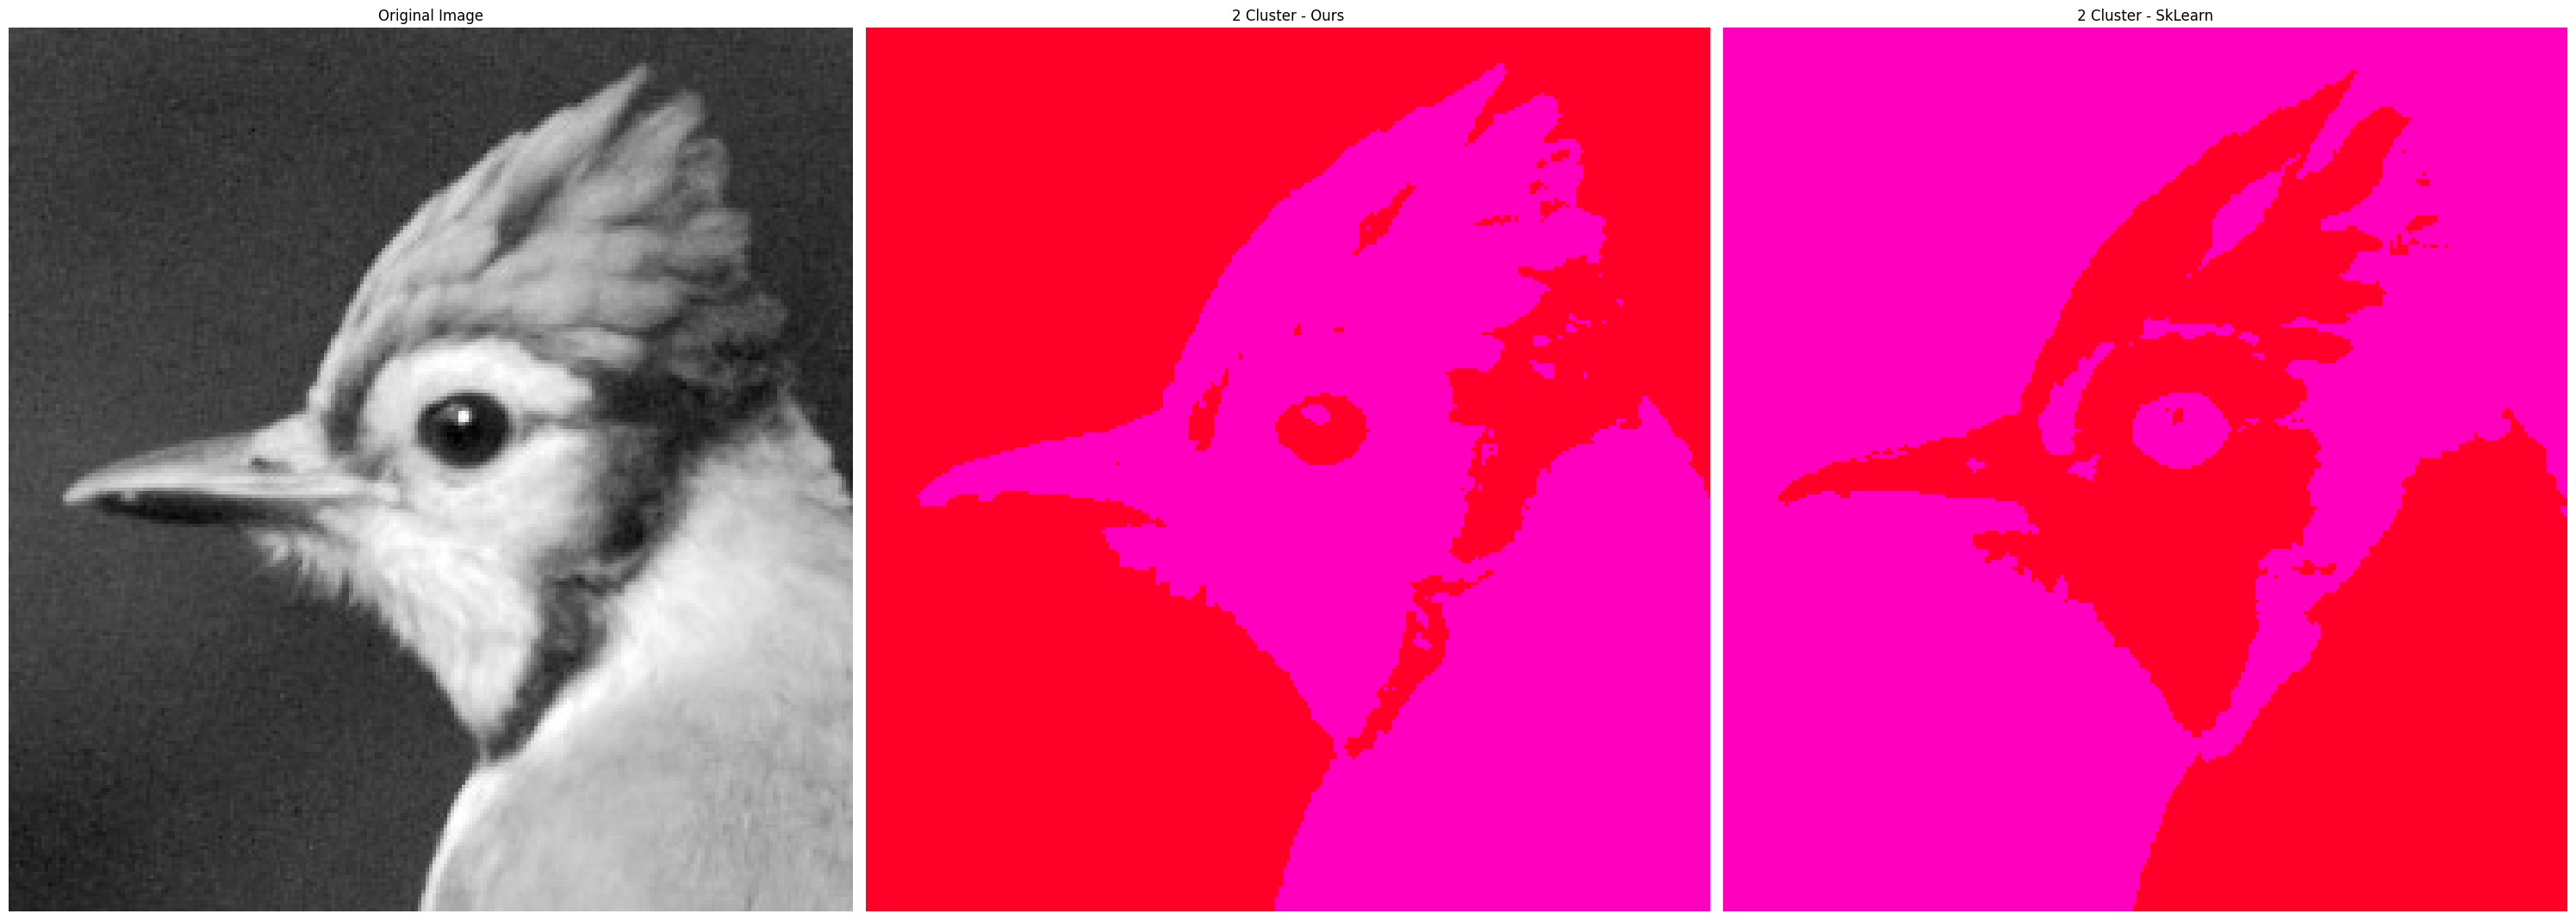

In [133]:
# K number of cluster
k = 2

# Run custom K-Means clustering on greyscale with k number of cluster
# Using my implementation for RGB, since it is dynamic and can handle RGB and Greyscale
centroids, labels = my_kmeans(gray_img[...,np.newaxis], k)

# Plot results
fig, ax = plt.subplots(1,3, figsize=(30, 60))
print(f"Cluster center: {centroids}")
ax[0].imshow(gray_img, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(labels, cmap='gist_rainbow')
ax[1].set_title(f"{k} Cluster - Ours")
ax[2].imshow(sk_g_2_kmeans_labels, cmap='gist_rainbow')
ax[2].set_title("2 Cluster - SkLearn")
for a in ax: a.axis('off')
fig.tight_layout()

### More things to try out:
1. Try different values for k. For k > 2 you will need some way to display the output L (other than simple black and white). Consider using a colour map with the imshow function.
2. Adapt your function so that it will handle colour images as well. What changes do you have to make?
3. Can you try some other distance functions, for instance, position + color difference

Cluster center: [[0.60262702 0.51017961 0.47631529]
 [0.83694059 0.76966745 0.74649663]
 [0.22117124 0.31871575 0.21191719]
 [0.32024253 0.365895   0.2626515 ]]


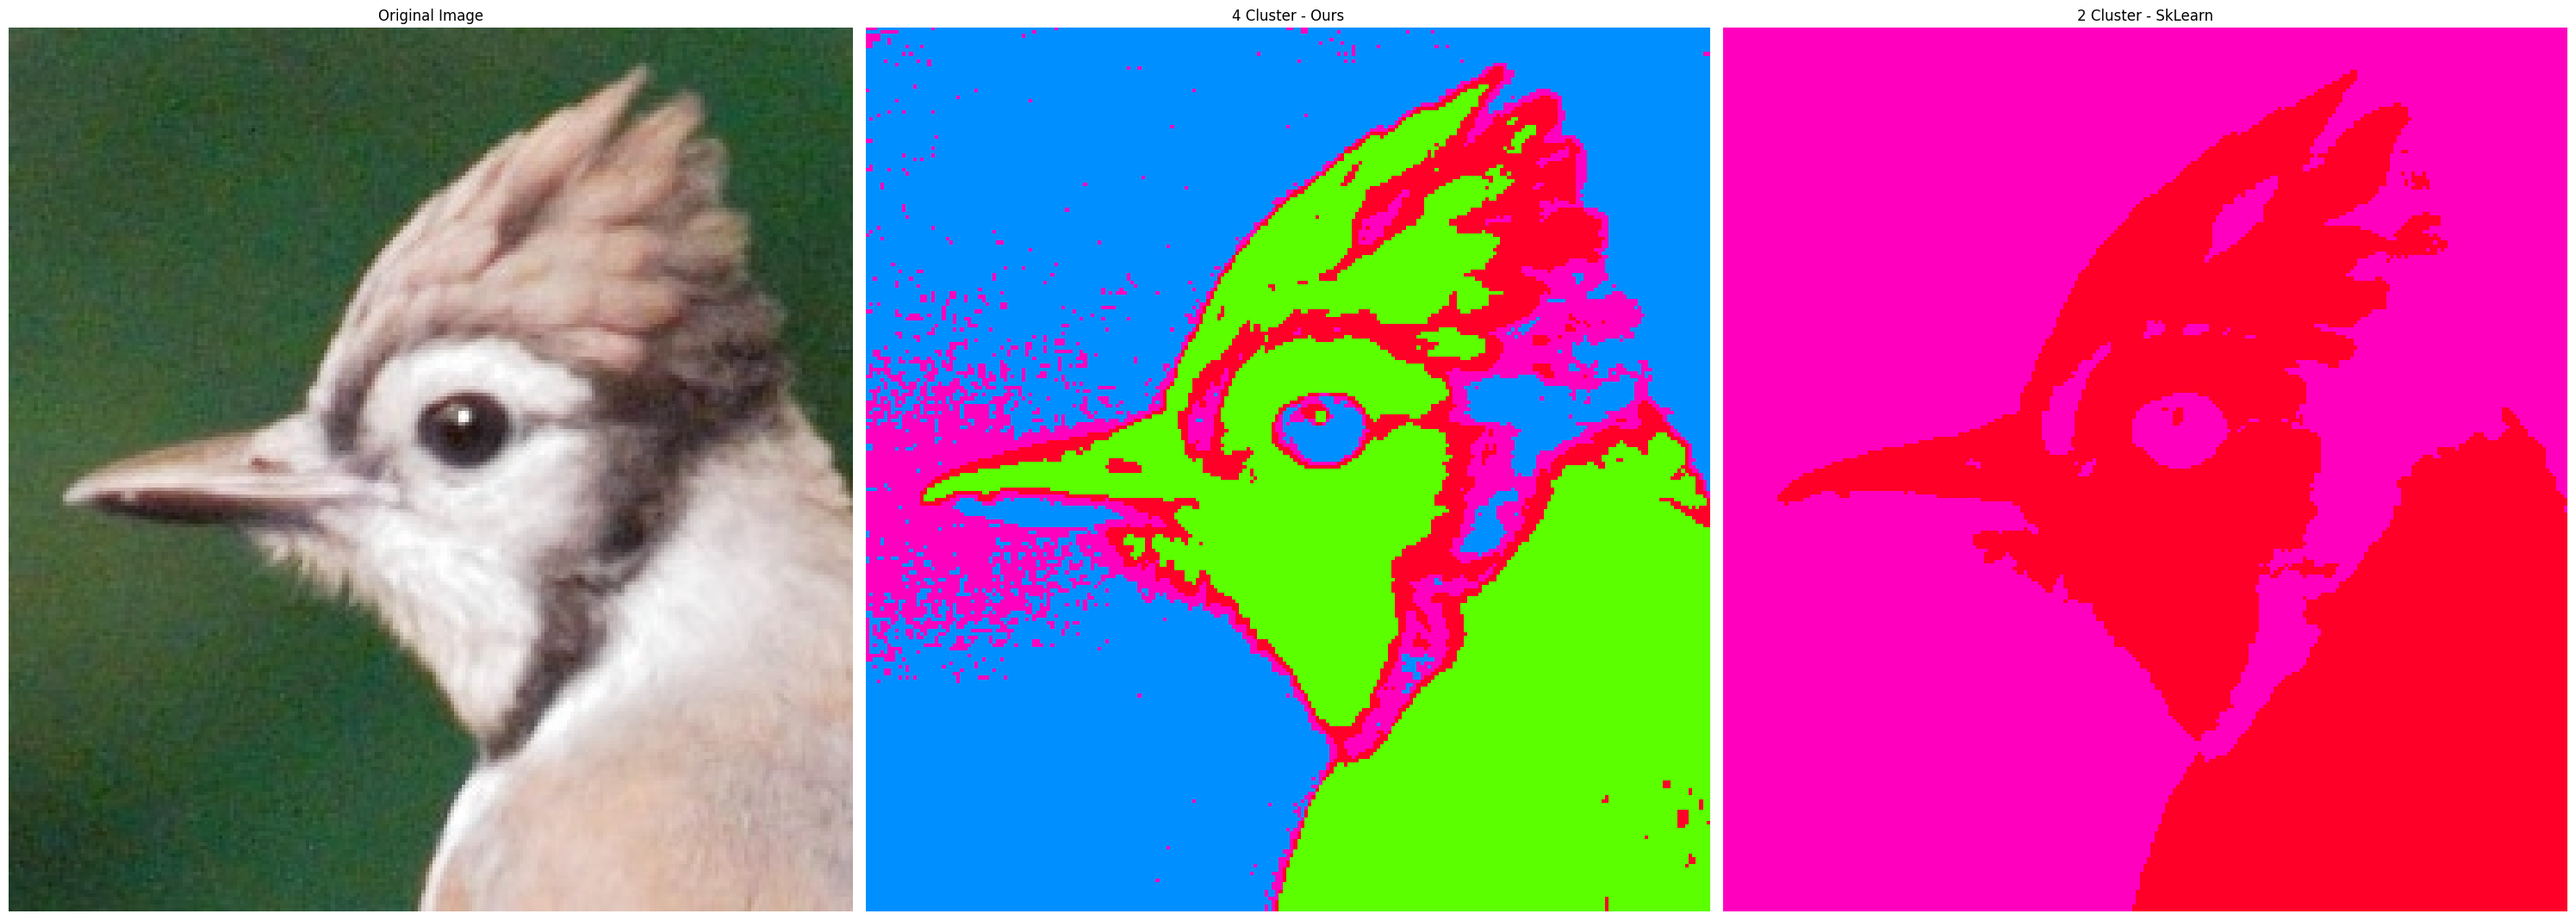

In [121]:
# K number of cluster
k = 4

# Run custom K-Means clustering on RGB with k number of cluster
centroids, labeled_img = my_kmeans(img, k)

# Plot results
fig, ax = plt.subplots(1,3, figsize=(30, 60))
print(f"Cluster center: {centroids}")
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(labeled_img, cmap='gist_rainbow')
ax[1].set_title(f"{k} Cluster - Ours")
ax[2].imshow(sk_rgb_2_kmeans_labels, cmap='gist_rainbow')
ax[2].set_title("2 Cluster - SkLearn")
for a in ax: a.axis('off')
fig.tight_layout()

Cluster center: [[0.39531869 0.41338944 0.33258481 0.19688159 0.57573452]
 [0.23360265 0.30408398 0.22124921 0.56801389 0.52761327]
 [0.22180723 0.3304156  0.21003179 0.51308362 0.14009627]
 [0.84932532 0.78863192 0.76873359 0.63440739 0.62271534]]


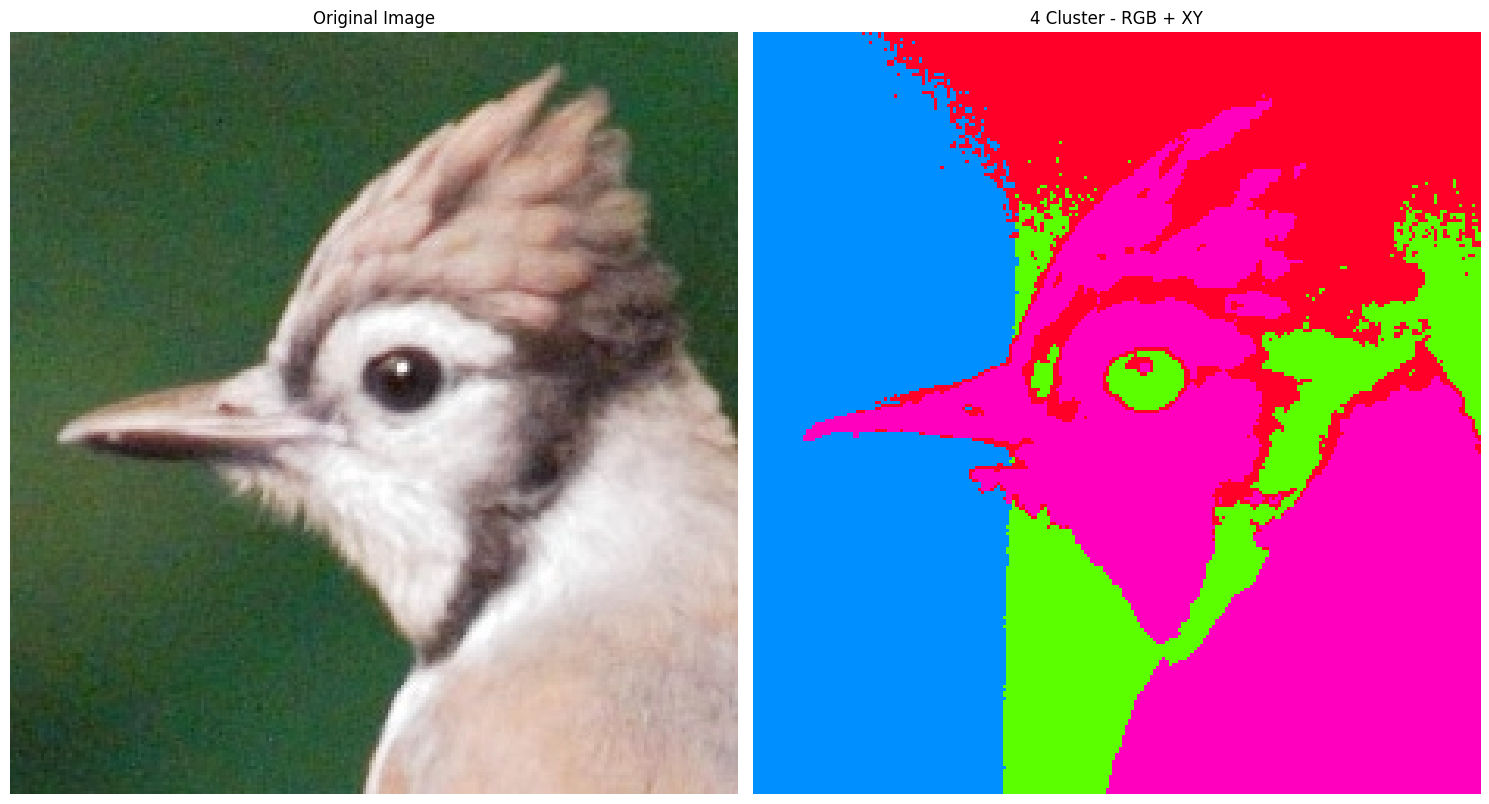

In [125]:
# Extend image array from RGB with XY coordinate to 5 channels that drive the clustering
# Combining color and location
x, y = np.meshgrid(np.arange(img.shape[0]),np.arange(img.shape[1]), indexing='ij')
img_rgb_coord = np.stack((img[...,0], img[...,1], img[...,2], x /255, y/255), axis=-1)

# K number of cluster
k = 4

# Run custom K-Means clustering on RGB with k number of cluster
centroids, labeled_img = my_kmeans(img_rgb_coord, k)

# Plot results
fig, ax = plt.subplots(1,2, figsize=(15, 30))
print(f"Cluster center: {centroids}")
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(labeled_img, cmap='gist_rainbow')
ax[1].set_title(f"{k} Cluster - RGB + XY")
for a in ax: a.axis('off')
fig.tight_layout()